#### Now that we have our designs of experiment, we can begin to create our metamodels. In our case, we will create 3 metamodels, each created from a different (in size and elements) design of experiment. We will then assess the precision of our metamodel in regard to the functions ouput, and further we will look at the sensitivities

In [1]:
import pandas as pd
import numpy as np
import openturns as ot
import pythontools as pt
from collections import Sequence, Iterable
import KarhunenLoeveFieldSensitivity as klfs

<ipython-input-1-340524c68602>:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, Iterable


In [2]:
# Lets' first load our 3 designs of experiment for the kriging models. 
# input designs : 
doe50_in = pd.read_csv('DOE_RESP2/kg_doe50_130875.csv', sep=';')
doe100_in = pd.read_csv('DOE_RESP2/kg_doe100_409484.csv', sep=';')
doe200_in = pd.read_csv('DOE_RESP2/kg_doe200_224409.csv', sep=';')
# model outputs :
doe50_out_MD = pd.read_csv('DOE_RESP2/kg_doe50_130875_resp_MD.csv', sep=';', header=None)
doe50_VM = pd.read_csv('DOE_RESP2/kg_doe50_130875_resp_VM.csv', sep=';', header=None)
doe100_out_MD = pd.read_csv('DOE_RESP2/kg_doe100_409484_resp_MD.csv', header=None)
doe100_VM = pd.read_csv('DOE_RESP2/kg_doe100_409484_resp_VM.csv', sep=';', header=None)
doe200_out_MD = pd.read_csv('DOE_RESP2/kg_doe200_224409_resp_MD.csv', sep=';', header=None)
doe200_VM = pd.read_csv('DOE_RESP2/kg_doe200_224409_resp_VM.csv', sep=';', header=None)
# validation models : 
doe_vali_200_in = pd.read_csv('DOE_RESP2/val_doe200_502849.csv', sep=';')
doe_vali_200_out_MD = pd.read_csv('DOE_RESP2/val_doe200_502849_resp_MD.csv', sep=';',header=None)
doe_vali_200_out_VM = pd.read_csv('DOE_RESP2/val_doe200_502849_resp_VM.csv', sep=';',header=None)

In [3]:
def all_same(items=None):
    #Checks if all items of a list are the same
    return all(x == items[0] for x in items)

def isValidSobolIndicesExperiment(sample_like, size, second_order = False):
    try :
        sample = np.asarray(sample_like)
    except :
        print('Could not convert sample to numpy array')
        raise TypeError
    N = sample.shape[0]
    print('N is', N)
    dim = sample.shape[1]
    Y_A = sample[:size]
    Y_B = sample[size:2*size]
    N_indice = int(N/size - 2)
    assert N%size==0,"wrong sample size"
    print('Simplified view of the sobol indices experiments structure')
    print('There are {} dimensions and {} sobol indices to calculate'.format(dim, N_indice))
    assert np.where(Y_A==Y_B,True,False).any() == False #Here we check that there is no similarity at all  between A and B 
    tot_lines = list()
    try : 
        for i in range(N_indice+2):
            Y_E = sample[i*size:(i+1)*size]
            tot_cols = [True]*dim
            col_where_A = list(set(np.argwhere(Y_A==Y_E)[:,1]))
            line_where_A = list(set(np.argwhere(Y_A==Y_E)[:,0]))
            if len(line_where_A)==size : OK = True
            for co in col_where_A :
                tot_cols[co] = False
            if OK : 
                if len(col_where_A)==dim and all(tot_cols):
                    sl = ['A_'+str(j) for j in range(dim)]
                elif len(col_where_A)==0 and all_same(tot_cols):
                    sl = ['B_'+str(j) for j in range(dim)]
                else :
                    sl = ['B_'+str(j) for j in range(dim)]
                    for k in range(len(col_where_A)):
                        sl[col_where_A[k]] = 'A_'+str(col_where_A[k])
                l = "  ,    ".join(sl)
                l = '    '+l
            if not OK :
                print('Error')
                return False
            tot_lines.append(l)
        repres = ' \n\n'.join(tot_lines)
        repres = '\n'+repres
        print(repres) 
        return True
    except :
        return False

def ereaseNanFromSample(sample_in, sample_out, N , secondOrder = False):
    sampOut = np.array(sample_out,copy=True, subok=False)
    if secondOrder == False : 
        n_vars = int(sampOut.shape[0]/N) - 2 
        print('n vars is', n_vars)
        N_max = int(N*(n_vars + 2))
        N_var = N_max/N
    else : 
        n_vars = int(sampOut.shape[0]/(N*2)) - 1
        print('n vars is', n_vars)
        N_max = int(N*(2*n_vars + 2))
        N_var = N_max/N
    
    print('N_max is', N_max)
    argNan = np.argwhere(np.isnan(sampOut))[:,0].tolist()
    print('args where nan : ',argNan)
    toErease = set()
    for arg in argNan:
        whereToErease = list(range(arg%N, N_max, N))
        [toErease.add(elem) for elem in whereToErease]
    whereToErease = list(toErease)
    print('Where we are erasing:', whereToErease)
    N -= int(len(whereToErease)/N_var)
    for idx in sorted(whereToErease)[::-1]:
        sample_in.erase(idx)
        sample_out.erase(idx) 
    print('N is now: ',N)
    return N

In [4]:
# KRIGING SAMPLE
    # INPUTS
sample_doe50_in = ot.Sample(doe50_in.values)
sample_doe50_in.setDescription(doe50_in.columns)
sample_doe100_in = ot.Sample(doe100_in.values)
sample_doe100_in.setDescription(doe100_in.columns)
sample_doe200_in = ot.Sample(doe200_in.values)
sample_doe200_in.setDescription(doe200_in.columns)
    # OUTPUTS
sample_doe50_out_MD = ot.Sample(doe50_out_MD.values)
sample_doe50_out_MD.setDescription(ot.Description.BuildDefault(len(doe50_out_MD.columns), 'MD_'))
sample_doe50_VM = ot.Sample(doe50_VM.values)
sample_doe50_VM.setDescription(ot.Description.BuildDefault(len(doe50_VM.columns), 'VM_'))
sample_doe100_out_MD = ot.Sample(doe100_out_MD.values)
sample_doe100_out_MD.setDescription(ot.Description.BuildDefault(len(doe100_out_MD.columns), 'MD_'))
sample_doe100_VM = ot.Sample(doe100_VM.values)
sample_doe100_VM.setDescription(ot.Description.BuildDefault(len(doe100_VM.columns), 'VM_'))
sample_doe200_out_MD = ot.Sample(doe200_out_MD.values)
sample_doe200_out_MD.setDescription(ot.Description.BuildDefault(len(doe200_out_MD.columns), 'MD_'))
sample_doe200_VM = ot.Sample(doe200_VM.values)
sample_doe200_VM.setDescription(ot.Description.BuildDefault(len(doe200_VM.columns), 'VM_'))
# VALIDATION SAMPLE
validation_sample_doe200_in = ot.Sample(doe_vali_200_in.values)
validation_sample_doe200_in.setDescription(doe_vali_200_in.columns)
validation_sample_doe200_out_MD = ot.Sample(doe_vali_200_out_MD.values)
validation_sample_doe200_out_MD.setDescription(ot.Description.BuildDefault(len(doe_vali_200_out_MD.columns), 'MD_'))
validation_sample_doe200_out_VM = ot.Sample(doe_vali_200_out_VM.values)
validation_sample_doe200_out_VM.setDescription(ot.Description.BuildDefault(len(doe_vali_200_out_VM.columns), 'VM_'))
sample_doe50_in.getDescription()

[X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]

## First, let's define a metamodeling class

In [5]:
class metamodeling_kriging : 
    def __init__(self, inSample, outSample, **kwargs):
        self.input_sample = inSample
        self.output_sample = outSample
        self.__default_kriging__ = None
        self.__kriging_theta__ = None
        self.__kriging_results__ = None
        self.__kriging_metamodel__ = None
        self.__size_multistart__ = kwargs['size_multistart'] if 'size_multistart' in kwargs else 5
        self.__lb__ = kwargs['lower_bound'] if 'lower_bound' in kwargs else None
        self.__ub__ = kwargs['upper_bound'] if 'upper_bound' in kwargs else None
        self.__optim_type__ = kwargs['optim_type'] if 'optim_type' in kwargs else 'best_start'
        self.validation_results = __validation_results__() 
        
    def _build_default(self):
        self.__default_kriging__ = pt.build_default_kriging_algo(
                                    input_sample  = self.input_sample,
                                    output_sample = self.output_sample, 
                                    basis         = None,
                                    covariance_model = None,
                                    noise         = None)
        
    def _estimate_theta(self):
        self.__kriging_theta__ = pt.estimate_kriging_theta(
                            algo_kriging = self.__default_kriging__,
                            lower_bound = self.__lb__,
                            upper_bound = self.__ub__,
                            size        = self.__size_multistart__,
                            optim_type  = self.__optim_type__)
    
    def _get_results_metamodel(self):
        if isinstance(self.__kriging_theta__,(Sequence,Iterable, list)):
            self.__kriging_results__ = [_kt.getResult() for _kt in self.__kriging_theta__]
            self.__kriging_metamodel__ = [_km.getMetaModel() for _km in self.__kriging_results__]
        else :
            self.__kriging_results__ = self.__kriging_theta__.getResult()
            self.__kriging_metamodel__ = self.__kriging_results__.getMetaModel()
                
    def run(self):
        self._build_default()
        self._estimate_theta()
        self._get_results_metamodel()
        print('Done !')
        
    def getKrigingResult(self):
        return self.__kriging_results__
        
    def getKrigingMetaModel(self):
        return self.__kriging_metamodel__
    
    def _check_clean_nans(self, sampleIn, sampleOut):
        whereNan = list(set(np.argwhere(np.isnan(sampleOut))[:,0]))
        print('NaN values found at index:',whereNan)
        [(sampleOut.erase(int(val)), sampleIn.erase(int(val))) for val in whereNan]
        
    def getMetaModelValidation(self, sample_in_validation, sample_out_validation):
        assert self.__kriging_metamodel__ is not None, "Please first run calculus"
        assert len(sample_in_validation) == len(sample_out_validation)
        self._check_clean_nans(sample_in_validation, sample_out_validation)
        self.validation_results.clear()
        if isinstance(self.__kriging_metamodel__,(Sequence,Iterable, list)):
            for i, model in enumerate(self.__kriging_metamodel__):
                validation = ot.MetaModelValidation(sample_in_validation, 
                                                    sample_out_validation[:,i],
                                                    self.__kriging_metamodel__[i])
                R2 = validation.computePredictivityFactor()
                residual = validation.getResidualSample()
                graph = validation.drawValidation()
                self.validation_results.addGraph(graph)
                self.validation_results.addR2(R2)
                self.validation_results.addResidual(residual)
        else : 
            validation = ot.MetaModelValidation(sample_in_validation, 
                                                sample_out_validation[:,0],
                                                self.__kriging_metamodel__)
            R2 = validation.computePredictivityFactor()
            residual = validation.getResidualSample()
            graph = validation.drawValidation()
            self.validation_results.addGraph(graph)
            self.validation_results.addR2(R2)
            self.validation_results.addResidual(residual)
                
class __validation_results__(object) :
    def __init__(self): 
        self.__R2__ = []
        self.__residuals__ = []
        self.__graphs__ = []

    def clear(self):
        self.__R2__.clear()
        self.__residuals__.clear()
        self.__graphs__.clear()
        
    def addGraph(self, graph):
        self.__graphs__.append(graph)

    def addR2(self, R2):
        self.__R2__.append(R2)

    def addResidual(self, residual):
        self.__residuals__.append(residual)

    def getGraphs(self):
        for graph in self.__graphs__ :
            ot.Show(graph)

    def getResiduals(self):
        theGraph = ot.Graph('Residuals','varying dimension','residual',True,'')
        theCurve = ot.Curve(list(range(len(self.__residuals__))),
                            self.__residuals__, 'residuals')
        theGraph.add(theCurve)
        ot.Show(theGraph)

    def getR2s(self):
        theGraph = ot.Graph('R2','varying dimension','residual',True,'')
        theCurve = ot.Curve(list(range(len(self.__R2__))),
                            self.__R2__, 'R2')
        theGraph.add(theCurve)
        ot.Show(theGraph)

#### First metamodel, DOE : LHS 50  ==> Max Deflection

In [6]:
kriging_doe_50_MD = metamodeling_kriging(sample_doe50_in, sample_doe50_out_MD,optim_type='multi_start', size_multistart = 10)
kriging_doe_50_MD.run()

Done !


###### For validation, we are going to use one of the samples intended for the sobol indices calculus. by the way, we are only going to use the 2/7 th of the samples (as we have samples A, B, and then 5 combinations of those.)

In [7]:
# validation_sample_doe2000_in | validation_sample_doe2000_out_MD | validation_sample_doe2000_out_VM
kriging_doe_50_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


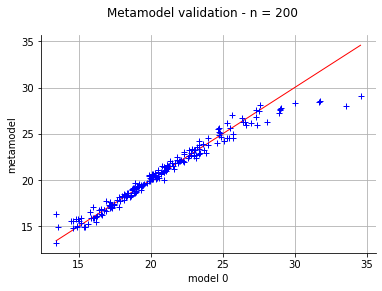

In [8]:
kriging_doe_50_MD.validation_results.getGraphs()

###### As we see, the results here are not so horrible ...

#### Second metamodel, DOE : LHS 100  ==> Max Deflection

In [9]:
kriging_doe_100_MD = metamodeling_kriging(sample_doe100_in, 
                                        sample_doe100_out_MD, 
                                        optim_type='best_start',
                                        size_multistart = 100,
                                        lower_bound = None,
                                        upper_bound = None)
kriging_doe_100_MD.run()

Done !


In [10]:
kriging_doe_100_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


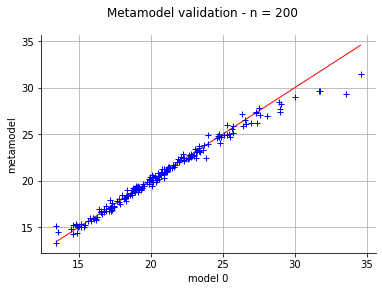

In [11]:

kriging_doe_100_MD.validation_results.getGraphs()

#### Third metamodel, DOE : LHS 200  ==> Max Deflection

In [12]:
kriging_doe_200_MD = metamodeling_kriging(sample_doe200_in, 
                                        sample_doe200_out_MD, 
                                        optim_type='best_start',
                                        size_multistart = 100,

                                        lower_bound = None,
                                        upper_bound = None)
kriging_doe_200_MD.run()

Done !


In [13]:
kriging_doe_200_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


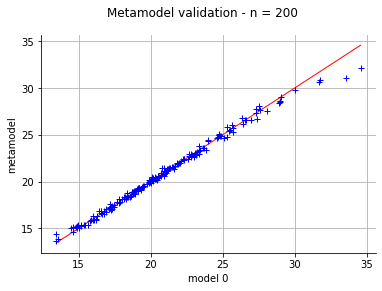

In [14]:
kriging_doe_200_MD.validation_results.getGraphs()

## Comparison of the sensitivity analysis parts. Let's do the sensitivty analysis of the 3 metamodels.

We will first have to load the sample intended to the calculus of the sobol indices, in hope we will find no nan. 

In [15]:
si_2000_in = pd.read_csv('DOE_RESP2/si_doe2000_720442.csv', sep=';')
si_2000_out_MD = pd.read_csv('DOE_RESP2/si_doe2000_720442_resp_MD.csv', sep=';',header=None)
si_2000_out_VM = pd.read_csv('DOE_RESP2/si_doe2000_720442_resp_VM.csv', sep=';',header=None)
#Samples
sample_si_2000_in = ot.Sample(si_2000_in.values)
sample_si_2000_in.setDescription(si_2000_in.columns)

sample_si_2000_out_MD = ot.Sample(si_2000_out_MD.values)
sample_si_2000_out_MD.setDescription(ot.Description.BuildDefault(len(si_2000_out_MD.columns), 'MD_'))

sample_si_2000_out_VM = ot.Sample(si_2000_out_VM.values)
sample_si_2000_out_VM.setDescription(ot.Description.BuildDefault(len(si_2000_out_VM.columns), 'VM_'))

si_1000_in = pd.read_csv('DOE_RESP2/si_doe1000_248214.csv', sep=';')
si_1000_out_MD = pd.read_csv('DOE_RESP2/si_doe1000_248214_resp_MD.csv', sep=';',header=None)
si_1000_out_VM = pd.read_csv('DOE_RESP2/si_doe1000_248214_resp_VM.csv', sep=';',header=None)
#Samples
sample_si_1000_in = ot.Sample(si_1000_in.values)
sample_si_1000_in.setDescription(si_1000_in.columns)

sample_si_1000_out_MD = ot.Sample(si_1000_out_MD.values)
sample_si_1000_out_MD.setDescription(ot.Description.BuildDefault(len(si_1000_out_MD.columns), 'MD_'))

sample_si_1000_out_VM = ot.Sample(si_1000_out_VM.values)
sample_si_1000_out_VM.setDescription(ot.Description.BuildDefault(len(si_1000_out_VM.columns), 'VM_'))
sample_si_2000_in.getSize()

12000

In [16]:
N_2000 = ereaseNanFromSample(sample_si_2000_in, sample_si_2000_out_MD, 2000, False)
sample_si_2000_in.getSize()


n vars is 4
N_max is 12000
args where nan :  []
Where we are erasing: []
N is now:  2000


12000

In [17]:
sample_si_2000_in[7777,5]=256
isValidSobolIndicesExperiment(sample_si_2000_in,N_2000)


N is 12000
Simplified view of the sobol indices experiments structure
There are 19 dimensions and 4 sobol indices to calculate

    A_0  ,    A_1  ,    A_2  ,    A_3  ,    A_4  ,    A_5  ,    A_6  ,    A_7  ,    A_8  ,    A_9  ,    A_10  ,    A_11  ,    A_12  ,    A_13  ,    A_14  ,    A_15  ,    A_16  ,    A_17  ,    A_18 

    B_0  ,    B_1  ,    B_2  ,    B_3  ,    B_4  ,    B_5  ,    B_6  ,    B_7  ,    B_8  ,    B_9  ,    B_10  ,    B_11  ,    B_12  ,    B_13  ,    B_14  ,    B_15  ,    B_16  ,    B_17  ,    B_18 

    B_0  ,    B_1  ,    B_2  ,    B_3  ,    B_4  ,    B_5  ,    B_6  ,    A_7  ,    A_8  ,    A_9  ,    A_10  ,    A_11  ,    A_12  ,    A_13  ,    A_14  ,    A_15  ,    A_16  ,    A_17  ,    A_18 

    A_0  ,    A_1  ,    A_2  ,    A_3  ,    A_4  ,    A_5  ,    A_6  ,    B_7  ,    B_8  ,    B_9  ,    B_10  ,    B_11  ,    B_12  ,    B_13  ,    B_14  ,    B_15  ,    B_16  ,    A_17  ,    A_18 

    A_0  ,    A_1  ,    A_2  ,    A_3  ,    A_4  ,    A_5  ,    A_6  ,    A_

True

NaN values found at index: []


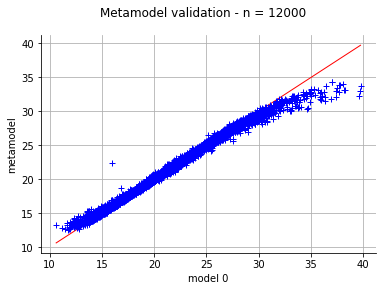

In [18]:
kriging_doe_200_MD.getMetaModelValidation(sample_si_2000_in, sample_si_2000_out_MD)
kriging_doe_200_MD.validation_results.getGraphs()
#Astuce / plan d'experience en augmentant coeff de variation des variables

In [19]:
N_1000 = ereaseNanFromSample(sample_si_1000_in, sample_si_1000_out_MD, 1000, False)

n vars is 4
N_max is 6000
args where nan :  []
Where we are erasing: []
N is now:  1000


NaN values found at index: []


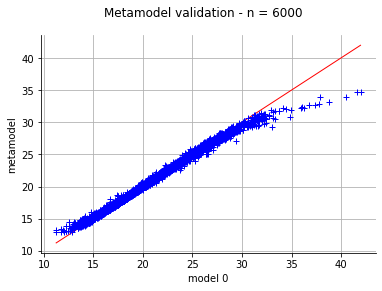

In [20]:
kriging_doe_200_MD.getMetaModelValidation(sample_si_1000_in, sample_si_1000_out_MD)
kriging_doe_200_MD.validation_results.getGraphs()

In [21]:
sensitivityAnalysis_REAL_MODEL_1000 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_REAL_MODEL_1000.setDesign(sample_si_1000_in, sample_si_1000_out_MD, N_1000)
sensitivityAnalysis_REAL_MODEL_1000.setEstimator(ot.SaltelliSensitivityAlgorithm())

size initialized 6000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7138]
design_elem size, dim 6000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']


In [22]:
import spsa 


In [23]:
analysis = spsa.SobolIndicesStochasticProcessAlgorithm(np.array(sample_si_1000_out_MD),N_1000)
analysis.getFirstOrderIndices()   ##### THE SOBOL INDICES CALCULUS IS RIGHT!!!! 

Implicit dimension = 4
Implicit description: [X0,X1,X2,X3]
There are 4 indices to get in (1,) dimensions with 1 elements
Indices successfully calculated


array([0.11734262, 0.95704434, 0.06066608, 0.15238758])

In [24]:
sensitivityAnalysis_REAL_MODEL_1000.getFirstOrderIndices()[0]

Solving...
 size of samples:  6000
 number of indices to get 4


[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.117343],
 class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.957083],
 class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[0.0606707],
 class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.152424]]

In [25]:
sensitivityAnalysis_REAL_MODEL_1000.__results__[0].getFirstOrderIndicesDistribution().getMarginal(0).getStandardDeviation()
res = sensitivityAnalysis_REAL_MODEL_1000.__results__[0]

In [26]:
sensitivityAnalysis_REAL_MODEL_1000.getFirstOrderIndicesInterval()[0]

class=Interval name=Bounds_Sobol_Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[0.0242711,0.79873,-0.0223008,0.0763594] upper bound=class=Point name=Unnamed dimension=4 values=[0.200873,1.14271,0.144791,0.231285] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [27]:
sensitivityAnalysis_REAL_MODEL_1000.getTotalOrderIndices()[0]

[class=Point name=TotalOrderSobol_Unnamed_X_0 dimension=1 values=[0.0486779],
 class=Point name=TotalOrderSobol_Unnamed_X_1 dimension=1 values=[0.828547],
 class=Point name=TotalOrderSobol_Unnamed_X_2 dimension=1 values=[0.00428605],
 class=Point name=TotalOrderSobol_Unnamed_X_3 dimension=1 values=[0.0677558]]

In [28]:
sensitivityAnalysis_REAL_MODEL_2000 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_REAL_MODEL_2000.setDesign(sample_si_2000_in, sample_si_2000_out_MD, N_2000)
sensitivityAnalysis_REAL_MODEL_2000.setEstimator(ot.SaltelliSensitivityAlgorithm())
sensitivityAnalysis_REAL_MODEL_2000.getFirstOrderIndices()[0]

size initialized 12000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.6965]
design_elem size, dim 12000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']
Solving...
 size of samples:  12000
 number of indices to get 4


[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0778157],
 class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.820848],
 class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[0.0154385],
 class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0885859]]

In [29]:
si_8000_in = pd.read_csv('DOE_RESP2/si_doe8000_439038.csv', sep=';')
si_8000_out_MD = pd.read_csv('DOE_RESP2/si_doe8000_439038_resp_MD.csv', sep=';',header=None)
si_8000_out_VM = pd.read_csv('DOE_RESP2/si_doe8000_439038_resp_VM.csv', sep=';',header=None)
#Samples
sample_si_8000_in = ot.Sample(si_8000_in.values)
sample_si_8000_in.setDescription(si_8000_in.columns)

sample_si_8000_out_MD = ot.Sample(si_8000_out_MD.values)
sample_si_8000_out_MD.setDescription(ot.Description.BuildDefault(len(si_8000_out_MD.columns), 'MD_'))

sample_si_8000_out_VM = ot.Sample(si_8000_out_VM.values)
sample_si_8000_out_VM.setDescription(ot.Description.BuildDefault(len(si_8000_out_VM.columns), 'VM_'))

In [30]:
whereNan = np.argwhere(np.isnan(sample_si_8000_out_MD))[:,0].tolist()
N = 8000
N_MAX = 8000*7
toDelete = set()
print('Where nan:', whereNan)
for idx in whereNan:
    toErease = list(range(idx%8000,N_MAX,N))
    [toDelete.add(elem) for elem in toErease]
print('toErease is', toDelete)
toDelete = list(toDelete)
N-=int(len(toDelete)/7)
for idx in sorted(toDelete)[::-1] :
    sample_si_8000_in.erase(idx)
    sample_si_8000_out_MD.erase(idx)
print('N=',N)

Where nan: []
toErease is set()
N= 8000


In [31]:
sensitivityAnalysis_REAL_MODEL2 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_REAL_MODEL2.setDesign(sample_si_8000_in, sample_si_8000_out_MD, N)
sensitivityAnalysis_REAL_MODEL2.setEstimator(ot.SaltelliSensitivityAlgorithm())

size initialized 48000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7134]
design_elem size, dim 48000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']


In [32]:
sensitivityAnalysis_REAL_MODEL2.getFirstOrderIndices()

Solving...
 size of samples:  48000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0611715],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.863026],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[-6.35862e-05],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0740651]]]

In [33]:
sensitivityAnalysis_REAL_MODEL2.getTotalOrderIndices()

[[class=Point name=TotalOrderSobol_Unnamed_X_0 dimension=1 values=[0.0633216],
  class=Point name=TotalOrderSobol_Unnamed_X_1 dimension=1 values=[0.869045],
  class=Point name=TotalOrderSobol_Unnamed_X_2 dimension=1 values=[0.00163586],
  class=Point name=TotalOrderSobol_Unnamed_X_3 dimension=1 values=[0.0742474]]]

As in this new sensitivity analysis are totally different from our first one, we have to check if either this analysis or the other is broken. For this we are first going to calculate the first and second order indices to see if something changes. 

In [34]:
si_sec_2000_in = pd.read_csv('DOE_RESP/si_sec_doe2000_8291001288.csv', sep=';')
si_sec_2000_out_MD = pd.read_csv('DOE_RESP/si_sec_doe2000_8291001288_resp_MD.csv', sep=';',header=None)
si_sec_2000_out_VM = pd.read_csv('DOE_RESP/si_sec_doe2000_8291001288_resp_VM.csv', sep=';',header=None)
#Samples
sample_si_sec_2000_in = ot.Sample(si_sec_2000_in.values)
sample_si_sec_2000_in.setDescription(si_sec_2000_in.columns)

sample_si_sec_2000_out_MD = ot.Sample(si_sec_2000_out_MD.values)
sample_si_sec_2000_out_MD.setDescription(ot.Description.BuildDefault(len(si_sec_2000_out_MD.columns), 'MD_'))

sample_si_sec_2000_out_VM = ot.Sample(si_sec_2000_out_VM.values)
sample_si_sec_2000_out_VM.setDescription(ot.Description.BuildDefault(len(si_sec_2000_out_VM.columns), 'VM_'))

In [35]:
N_sec_2000 = ereaseNanFromSample(sample_si_sec_2000_in , sample_si_sec_2000_out_MD, 2000, True)


n vars is 5
N_max is 24000
args where nan :  []
Where we are erasing: []
N is now:  2000


In [36]:
isValidSobolIndicesExperiment(sample_si_sec_2000_in, N_sec_2000,True)

N is 24000
Simplified view of the sobol indices experiments structure
There are 20 dimensions and 10 sobol indices to calculate

    A_0  ,    A_1  ,    A_2  ,    A_3  ,    A_4  ,    A_5  ,    A_6  ,    A_7  ,    A_8  ,    A_9  ,    A_10  ,    A_11  ,    A_12  ,    A_13  ,    A_14  ,    A_15  ,    A_16  ,    A_17  ,    A_18  ,    A_19 

    B_0  ,    B_1  ,    B_2  ,    B_3  ,    B_4  ,    B_5  ,    B_6  ,    B_7  ,    B_8  ,    B_9  ,    B_10  ,    B_11  ,    B_12  ,    B_13  ,    B_14  ,    B_15  ,    B_16  ,    B_17  ,    B_18  ,    B_19 

    B_0  ,    B_1  ,    B_2  ,    B_3  ,    B_4  ,    B_5  ,    B_6  ,    A_7  ,    A_8  ,    A_9  ,    A_10  ,    A_11  ,    A_12  ,    A_13  ,    A_14  ,    A_15  ,    A_16  ,    A_17  ,    A_18  ,    A_19 

    A_0  ,    A_1  ,    A_2  ,    A_3  ,    A_4  ,    A_5  ,    A_6  ,    B_7  ,    B_8  ,    B_9  ,    B_10  ,    B_11  ,    B_12  ,    B_13  ,    B_14  ,    B_15  ,    B_16  ,    A_17  ,    A_18  ,    A_19 

    A_0  ,    A_1  ,    A_2  , 

True

In [37]:
sensitivityAnalysis_REAL_MODEL2 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_REAL_MODEL2.setDesign(sample_si_sec_2000_in, sample_si_sec_2000_out_MD, N_sec_2000)
sensitivityAnalysis_REAL_MODEL2.setEstimator(ot.SaltelliSensitivityAlgorithm())
sensitivityAnalysis_REAL_MODEL2.setComputeSecondOrder(True)

size initialized 24000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [21.5161]
design_elem size, dim 24000 1
There are 10 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0,X_4_0]#20
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']
size initialized 24000
Means is
 [21.5161]
design_elem size, dim 24000 1
There are 5 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0,X_4_0]#20
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']


In [38]:
sensitivityAnalysis_REAL_MODEL2.inputDescription
sensitivityAnalysis_REAL_MODEL2.__nSobolIndices__
sensitivityAnalysis_REAL_MODEL2.size

24000

In [39]:
sensitivityAnalysis_REAL_MODEL2.getFirstOrderIndices()

Solving...
 size of samples:  24000
 number of indices to get 5


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.901938],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.142138],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[0.00531224],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.00594331],
  class=Point name=Sobol_Unnamed_X_4 dimension=1 values=[0.0452291]]]

In [40]:
sensitivityAnalysis_REAL_MODEL2.getSecondOrderIndices()

This makes a problem: [class=SymmetricMatrix dimension=5 implementation=class=MatrixImplementation name=Unnamed rows=5 columns=5 values=[0,-0.137989,-0.117348,-0.103721,-0.11729,-0.137989,0,-0.0097177,-0.00813538,-0.0111993,-0.117348,-0.0097177,0,-0.0106218,-0.0106218,-0.103721,-0.00813538,-0.0106218,0,-0.0112653,-0.11729,-0.0111993,-0.0106218,-0.0112653,0]]


[class=SymmetricMatrix dimension=5 implementation=class=MatrixImplementation name=Unnamed rows=5 columns=5 values=[0,-0.137989,-0.117348,-0.103721,-0.11729,-0.137989,0,-0.0097177,-0.00813538,-0.0111993,-0.117348,-0.0097177,0,-0.0106218,-0.0106218,-0.103721,-0.00813538,-0.0106218,0,-0.0112653,-0.11729,-0.0111993,-0.0106218,-0.0112653,0]]

In [41]:
si_10000_in = pd.read_csv('./inp_10000.csv', sep=';')
si_10000_out_MD = pd.read_csv('./out_10000_MD.csv', sep=';')
si_10000_out_VM = pd.read_csv('./out_10000_VM.csv', sep=';')

In [42]:
si_10000_in = pd.read_csv('./inp_10000.csv', sep=';')
si_10000_out_MD = pd.read_csv('./out_10000_MD.csv', sep=';',header=None)
si_10000_out_VM = pd.read_csv('./out_10000_VM.csv', sep=';',header=None)
#Samples
sample_si_10000_in = ot.Sample(si_10000_in.values)
sample_si_10000_in.setDescription(si_10000_in.columns)

sample_si_10000_out_MD = ot.Sample(si_10000_out_MD.values)
sample_si_10000_out_MD.setDescription(ot.Description.BuildDefault(len(si_10000_out_MD.columns), 'MD_'))

sample_si_10000_out_VM = ot.Sample(si_10000_out_VM.values)
sample_si_10000_out_VM.setDescription(ot.Description.BuildDefault(len(si_10000_out_VM.columns), 'VM_'))

In [43]:
sensitivityAnalysis_10000 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_10000.setDesign(sample_si_10000_in, sample_si_10000_out_MD, 10000)
sensitivityAnalysis_10000.setEstimator(ot.SaltelliSensitivityAlgorithm())

size initialized 60000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7275]
design_elem size, dim 60000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']


In [44]:
sensitivityAnalysis_10000.getFirstOrderIndices()

Solving...
 size of samples:  60000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0501579],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.837902],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[-0.00159541],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0751376]]]

In [45]:
sensitivityAnalysis_10000.getFirstOrderIndicesInterval()[0]

class=Interval name=Bounds_Sobol_Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[0.0284561,0.790927,-0.0239276,0.0533675] upper bound=class=Point name=Unnamed dimension=4 values=[0.0697366,0.887544,0.0179894,0.0965129] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [46]:
sensitivityAnalysis_10000_2 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_10000_2.setDesign(sample_si_10000_in, sample_si_10000_out_MD, 10000)
sensitivityAnalysis_10000_2.setEstimator(ot.MartinezSensitivityAlgorithm())
sensitivityAnalysis_10000_2.getFirstOrderIndices()

size initialized 60000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7275]
design_elem size, dim 60000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']
Solving...
 size of samples:  60000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.051123],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.859528],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[-0.00161646],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0767474]]]

In [47]:
sensitivityAnalysis_10000_2.getFirstOrderIndicesInterval()[0]

class=Interval name=Bounds_Sobol_Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[0.0261763,0.854213,-0.0280811,0.0500413] upper bound=class=Point name=Unnamed dimension=4 values=[0.0735559,0.865722,0.0209563,0.0986617] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [48]:
import spsa

In [49]:
analysis2 = spsa.SobolIndicesStochasticProcessAlgorithm(np.array(sample_si_10000_out_MD),10000)
analysis2.getFirstOrderIndices()

Implicit dimension = 4
Implicit description: [X0,X1,X2,X3]
There are 4 indices to get in (1,) dimensions with 1 elements
Indices successfully calculated


array([ 0.05011829,  0.83783865, -0.00159235,  0.07515936])

In [50]:
analysis2.getFirstOrderIndicesInterval()

array([0.01627396, 0.03526993, 0.01620656, 0.01622444])

In [51]:
si_50000_in = pd.read_csv('./inp_50000.csv', sep=';')
si_50000_out_MD = pd.read_csv('./out_50000_MD.csv', sep=';',header=None)
si_50000_out_VM = pd.read_csv('./out_50000_VM.csv', sep=';',header=None)
#Samples
sample_si_50000_in = ot.Sample(si_50000_in.values)
sample_si_50000_in.setDescription(si_50000_in.columns)

sample_si_50000_out_MD = ot.Sample(si_50000_out_MD.values)
sample_si_50000_out_MD.setDescription(ot.Description.BuildDefault(len(si_50000_out_MD.columns), 'MD_'))

sample_si_50000_out_VM = ot.Sample(si_50000_out_VM.values)
sample_si_50000_out_VM.setDescription(ot.Description.BuildDefault(len(si_50000_out_VM.columns), 'VM_'))

In [52]:
sensitivityAnalysis_50000 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_50000.setDesign(sample_si_50000_in, sample_si_50000_out_MD, 50000)
sensitivityAnalysis_50000.setEstimator(ot.SaltelliSensitivityAlgorithm())

size initialized 300000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7659]
design_elem size, dim 300000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']


In [53]:
sensitivityAnalysis_50000.getFirstOrderIndices()

Solving...
 size of samples:  300000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0608891],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.847223],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[0.00667599],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0805131]]]

In [54]:
sensitivityAnalysis_50000.getFirstOrderIndicesInterval()[0]

class=Interval name=Bounds_Sobol_Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[0.0517646,0.829002,-0.0030981,0.0701424] upper bound=class=Point name=Unnamed dimension=4 values=[0.0717052,0.864777,0.017723,0.0918275] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [55]:
sensitivityAnalysis_50000 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_50000.setDesign(sample_si_50000_in, sample_si_50000_out_MD, 50000)
sensitivityAnalysis_50000.setEstimator(ot.MartinezSensitivityAlgorithm())

size initialized 300000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7659]
design_elem size, dim 300000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']


In [56]:
sensitivityAnalysis_50000.getFirstOrderIndices()

Solving...
 size of samples:  300000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0614971],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.862613],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[0.00674429],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0812005]]]

In [57]:
sensitivityAnalysis_50000.getFirstOrderIndicesInterval()[0]

class=Interval name=Bounds_Sobol_Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[0.0526769,0.859877,-0.00146918,0.0729915] upper bound=class=Point name=Unnamed dimension=4 values=[0.072841,0.865365,0.0187525,0.0941991] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [58]:
analysis50000 = spsa.SobolIndicesStochasticProcessAlgorithm(np.array(sample_si_50000_out_MD),50000)
analysis50000.getFirstOrderIndices()

Implicit dimension = 4
Implicit description: [X0,X1,X2,X3]
There are 4 indices to get in (1,) dimensions with 1 elements
Indices successfully calculated


array([0.06089348, 0.84720353, 0.00667668, 0.08050193])

In [59]:
analysis50000.getFirstOrderIndicesInterval()

array([0.00727165, 0.01538639, 0.00717851, 0.00729869])

### Sensitivity analysis of the metamodels 

Here we are going to do the same sensitivity analysis, but based on the metamodel of the bending beam model. 


In [63]:
kriging_doe_200_MD.__kriging_metamodel__.getInputDimension()

19

In [69]:
inp_50000 = pd.read_csv('./inp_50000.csv', sep=';')
sample_inp_50000 = ot.Sample(inp_50000.values)
sample_inp_50000.setDescription(inp_50000.columns)

In [70]:
inp_50000

,X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0
0,-0.834194,-0.486636,-0.570356,0.846220,-1.034956,0.712368,-1.032458,-0.738593,0.070983,-0.366800,-0.667345,1.767240,-0.158158,1.183266,0.495704,0.629103,-0.815190,0.818771,-0.551015
1,-0.117347,-0.376034,-0.524341,1.024997,1.731299,-1.236952,-0.309832,0.450524,-0.267513,1.539146,1.152710,1.367701,0.120564,-1.528836,-0.149897,0.756133,-0.935915,0.544425,-0.159702
2,-0.689586,0.239030,0.212964,0.628651,-0.855127,-0.236020,0.623402,-0.237840,0.233623,-0.029758,-0.205822,-0.317068,-0.189313,1.094972,-0.967281,0.724391,-0.316394,0.161818,2.090907
3,0.283831,0.084010,0.059867,0.413641,-0.593910,0.795025,-0.013813,-1.111877,-1.507806,1.167382,-2.125695,-0.879029,1.488192,-1.617035,-0.051941,-1.430237,-0.354993,-2.067386,-0.997259
4,-2.199463,0.774483,0.845330,0.859763,1.436971,-0.277666,-0.506746,-0.528269,-0.777526,-0.416281,2.411135,0.788100,1.512947,-0.146944,1.673533,-0.906167,-0.592085,0.523040,-0.110810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.196340,0.352494,-0.217923,-1.444372,0.471152,-1.383772,-2.096909,0.662194,-1.074535,0.940905,1.020807,2.376940,-0.613947,-0.935909,-0.484643,0.134642,0.598082,0.926569,-0.348272
59996,0.054929,0.039862,-0.421047,-0.900226,0.242575,-0.053340,0.717615,0.152399,-0.405487,-0.172989,-0.936347,-1.589312,1.252332,-0.257872,0.202642,1.462633,0.672277,0.258019,0.253817
59997,1.365874,0.498793,-0.979857,0.486504,-0.086087,-1.071370,-0.612456,0.687291,1.545017,-1.166236,-0.377322,1.827107,0.285564,-0.658491,0.220944,0.807738,-0.462367,0.150283,-0.806112
59998,0.307724,0.020850,1.025259,0.000589,0.523252,0.321315,-0.897799,0.806636,0.004824,1.342516,-0.180256,-1.301152,2.139533,0.698171,1.256902,0.389617,1.457361,-0.498108,-1.687677


In [75]:
resp_meatamodel50000 = kriging_doe_200_MD.__kriging_metamodel__(sample_inp_50000)

In [78]:
sample_inp_50000

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=60000 dimension=19 description=[X_0_0,X_0_1,X_0_2,...,X_1_9,X_2_0,X_3_0] data=[[-0.834194,-0.486636,-0.570356,...,-0.81519,0.818771,-0.551015],[-0.117347,-0.376034,-0.524341,...,-0.935915,0.544425,-0.159702],[-0.689586,0.23903,0.212964,...,-0.316394,0.161818,2.09091],...,[1.36587,0.498793,-0.979857,...,-0.462367,0.150283,-0.806112],[0.307724,0.0208495,1.02526,...,1.45736,-0.498108,-1.68768],[-0.025674,-1.13588,0.138926,...,0.552805,0.394473,-0.71955]]

In [79]:
sensitivityAnalysis_10000_2 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_10000_2.setDesign(sample_inp_50000, resp_meatamodel50000, 10000)
sensitivityAnalysis_10000_2.setEstimator(ot.MartinezSensitivityAlgorithm())
sensitivityAnalysis_10000_2.getFirstOrderIndices()

size initialized 60000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [20.7371]
design_elem size, dim 60000 1
There are 4 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_0_1,X_0_2,X_0_3,X_0_4,X_0_5,X_0_6,X_1_0,X_1_1,X_1_2,X_1_3,X_1_4,X_1_5,X_1_6,X_1_7,X_1_8,X_1_9,X_2_0,X_3_0]#19
SobolIndicesName ['X_0', 'X_1', 'X_2', 'X_3']
Input Description is, ['X_0', 'X_1', 'X_2', 'X_3']
Solving...
 size of samples:  60000
 number of indices to get 4


[[class=Point name=Sobol_Unnamed_X_0 dimension=1 values=[0.0478085],
  class=Point name=Sobol_Unnamed_X_1 dimension=1 values=[0.866107],
  class=Point name=Sobol_Unnamed_X_2 dimension=1 values=[-0.00186701],
  class=Point name=Sobol_Unnamed_X_3 dimension=1 values=[0.0768463]]]

Refaire experience avec les mêmes samples pour le métamodele et le vrai modèle. 
(Plus vérification avec assert_equal() )
Nouveau Notebook plus concis + calculs R2 + graphes + introduire coef var dans params entrée + simplifier fonctions et mettre dans fichier à part. 
Cas tests :
  - D'abord kriegage (modifs taille DOE LHS) + écarts vrai modèle /metamodele
  - Sur paramètres entrée (variance, amplitude, scale... ) 
  - Sauvegarder chaque resultat
  - DF Pandas: ordonnées (indices de sobol) | abscisses : (Taille DOE due kriegage + taille plan d'experience) 
  - Tests chaos polynomial + visualisation + (analyser IS des sigma et des params) 